In [1]:
TODAY="2021-11-13"
TASK = "phylogenetic-determination"
DIR = "$(homedir())/$(TODAY)-$(TASK)"
if !isdir(DIR)
    mkdir(DIR)
end
cd(DIR)

In [2]:
# alternative workflow would be to utilize ezAAI http://leb.snu.ac.kr/ezaai
# or recreate ezAAI with diamond

# use the genus assignment of the phage, and then assume the family level assignment from the genus classification
# require that scale dependent, correlation, and probability based genus is consisent, otherwise flag

In [3]:
import Pkg

pkgs = [
"JSON",
"HTTP",
"Dates",
"uCSV",
"DelimitedFiles",
"DataFrames",
"ProgressMeter",
"BioSequences",
"FASTX",
"Distances",
"Plots",
"StatsPlots",
"StatsBase",
"Statistics",
"Mmap",
"MultivariateStats",
"PyCall",
"Random",
"Primes",
"Revise",
"SparseArrays",
"SHA",
"Mycelia",
"GenomicAnnotations",
"BioFetch",
"Combinatorics",
"StaticArrays",
"BioSymbols",
"RollingFunctions",
"OrderedCollections"
]

for pkg in pkgs
    try
        eval(Meta.parse("import $pkg"))
    catch
        Pkg.add(pkg)
        eval(Meta.parse("import $pkg"))
    end
end

In [4]:
function generate_all_possible_kmers(k, alphabet)
    kmer_iterator = Iterators.product([alphabet for i in 1:k]...)
    kmer_vectors = collect.(vec(collect(kmer_iterator)))
    if eltype(alphabet) == BioSymbols.AminoAcid
        kmers = BioSequences.LongAminoAcidSeq.(kmer_vectors)
    elseif eltype(alphabet) == BioSymbols.DNA
        kmers = BioSequences.LongDNASeq.(kmer_vectors)
    else
        error()
    end
    return sort!(kmers)
end

function generate_all_possible_canonical_kmers(k, alphabet)
    kmers = generate_all_possible_kmers(k, alphabet)
    if eltype(alphabet) == BioSymbols.AminoAcid
        return kmers
    elseif eltype(alphabet) == BioSymbols.DNA
        return BioSequences.DNAMer.(unique!(BioSequences.canonical.(kmers)))
    else
        error()
    end
end

generate_all_possible_canonical_kmers (generic function with 1 method)

In [5]:
function count_canonical_aamers(k, fasta_proteins)
    aamer_counts = OrderedCollections.OrderedDict{BioSequences.LongAminoAcidSeq, Int64}()
    for protein in fasta_proteins
        s = FASTX.sequence(protein)
        these_counts = sort(StatsBase.countmap([s[i:i+k-1] for i in 1:length(s)-k-1]))
        merge!(+, aamer_counts, these_counts)
    end
    return sort(aamer_counts)
end

count_canonical_aamers (generic function with 1 method)

In [6]:
function update_counts_matrix!(matrix, sample_index, countmap, sorted_kmers)
    for (i, kmer) in enumerate(sorted_kmers)
        matrix[i, sample_index] = get(countmap, kmer, 0)
    end
    return matrix
end

update_counts_matrix! (generic function with 1 method)

In [7]:
function accession_list_to_counts_table(;accession_list, k, alphabet, outfile="")
    if alphabet == :AA
        canonical_mers = generate_all_possible_canonical_kmers(k, AA_ALPHABET)
    elseif alphabet == :DNA
        canonical_mers = generate_all_possible_canonical_kmers(k, DNA_ALPHABET)
    else
        error("invalid alphabet")
    end
    if isempty(outfile)
        outfile = joinpath(pwd(), "$(hash(accession_list)).$(alphabet).k$(k).bin")
    end
    if isfile(outfile)
        println("$outfile found, loading into memory")
        mer_counts_matrix = Mmap.mmap(outfile, Array{Int, 2}, (length(canonical_mers), length(accession_list)))
    else
        println("creating new counts matrix $outfile")
        mer_counts_matrix = Mmap.mmap(outfile, Array{Int, 2}, (length(canonical_mers), length(accession_list)))
        mer_counts_matrix .= 0
        ProgressMeter.@showprogress for (entity_index, accession) in enumerate(accession_list)
            fna_file = "$(accession).fna"
            if !isfile(fna_file)
                open(FASTX.FASTA.Writer, fna_file) do fastx_io
                    for record in Mycelia.get_sequence(db="nuccore", accession = accession)
                        write(fastx_io, record)
                    end
                end
            end
            if alphabet == :DNA
                entity_mer_counts = Mycelia.count_canonical_kmers(BioSequences.DNAMer{dna_k}, fna_file)
            elseif alphabet == :AA
                faa_file = "$(accession).fna.faa"
                if !isfile(faa_file)
                    run(pipeline(`prodigal -i $(fna_file) -o $(fna_file).genes -a $(faa_file) -p meta`, stderr="$(fna_file).prodigal.stderr"))
                end
                entity_mer_counts = count_canonical_aamers(aa_k, collect(FASTX.FASTA.Reader(open(faa_file))))
            end
            update_counts_matrix!(mer_counts_matrix, entity_index, entity_mer_counts, canonical_mers)            
        end
    end
    return mer_counts_matrix, outfile
end

accession_list_to_counts_table (generic function with 1 method)

In [8]:
function normalize_distance_matrix(distance_matrix)
    max_non_nan_value = maximum(filter(x -> !isnan(x) && !isnothing(x) && !ismissing(x), vec(distance_matrix)))
    return distance_matrix ./ max_non_nan_value
end

normalize_distance_matrix (generic function with 1 method)

In [9]:
function count_matrix_to_probability_matrix(counts_matrix, counts_matrix_file)
    probability_matrix_file = replace(counts_matrix_file, ".bin" => ".probability_matrix.bin")
    already_there = isfile(probability_matrix_file)
    probability_matrix = Mmap.mmap(probability_matrix_file, Array{Float64, 2}, size(counts_matrix))
    if !already_there
        println("creating new probability matrix $probability_matrix_file")
        for (i, col) in enumerate(eachcol(counts_matrix))
            probability_matrix[:, i] .= col ./ sum(col)
        end
    else
        println("probability matrix found $probability_matrix_file")
    end
    return probability_matrix, probability_matrix_file
end

count_matrix_to_probability_matrix (generic function with 1 method)

In [10]:
# MYCELIA_METADATA = joinpath(Pkg.dir("Mycelia"), "metadata")
MYCELIA_METADATA = joinpath(dirname(dirname(pathof(Mycelia))),  "metadata")

"/home/jupyter-cjprybol/.julia/dev/Mycelia/metadata"

In [11]:
# AA_ALPHABET = collect(filter(x -> x != BioSequences.AA_Term, Mycelia.AA_ALPHABET))
AA_ALPHABET = Mycelia.AA_ALPHABET
DNA_ALPHABET = Mycelia.DNA_ALPHABET

(DNA_A, DNA_C, DNA_G, DNA_T)

In [12]:
results = 
DataFrames.DataFrame(
    n = Int[],
    grammar = String[],
    distance_metric = [],
    genus_accuracy = Float64[],
    family_accuracy = Float64[],
    min_distances = Vector{Float64}[]
)

,n,grammar,distance_metric,genus_accuracy,family_accuracy,min_distances
,Int64,String,Any,Float64,Float64,Array…


In [13]:
# cosine distance is slower than correlation distance
# city block is faster than euclidean
# total variation is fastest probability measure

In [14]:
# kill_js_divergence
distance_matrix_map = Dict(
    Distances.euclidean => "count",
    Distances.cityblock => "count",
    Distances.corr_dist => "count",
    Distances.cosine_dist => "count",
    Distances.totalvariation => "probability",
#     Distances.js_divergence => "probability", too slow
#     Distances.bhattacharyya => "probability",
#     Distances.hellinger => "probability",
)

Dict{Distances.SemiMetric, String} with 5 entries:
  CosineDist()     => "count"
  CorrDist()       => "count"
  Cityblock()      => "count"
  Euclidean(0.0)   => "count"
  TotalVariation() => "probability"

In [15]:
# these are too small, all of the within vs between have some disagreement
# dna_k = 5
# aa_k = 2
dna_k = 7
aa_k = 3

3

In [16]:
# https://www.ncbi.nlm.nih.gov/labs/virus/vssi/#/virus?SeqType_s=Nucleotide&VirusLineage_ss=Bacteriophage,%20all%20taxids&Completeness_s=complete
entity_metadata_full = DataFrames.DataFrame(uCSV.read("$(MYCELIA_METADATA)/2021-11-13-ncbi-complete-bacteriophage.csv", header=1, quotes='"')...)
sort!(entity_metadata_full, "Accession")
entity_metadata_full = entity_metadata_full[entity_metadata_full[!, "Nuc_Completeness"] .== "complete", :]
# filter down to only include labelled genera
entity_metadata_full = entity_metadata_full[.!isempty.(entity_metadata_full[!, "Genus"]), :]
# filter down to only include genera that are present at least once
genera_counts = sort(collect(StatsBase.countmap(entity_metadata_full[!, "Genus"])), by=x->x[2], rev=true)

964-element Vector{Pair{String, Int64}}:
       "Fromanvirus" => 905
     "Gequatrovirus" => 371
      "Cheoctovirus" => 317
        "Skunavirus" => 311
       "Pegunavirus" => 240
     "Tequatrovirus" => 222
    "Timquatrovirus" => 212
       "Pahexavirus" => 201
      "Bixzunavirus" => 174
        "Pbunavirus" => 168
   "Sinsheimervirus" => 156
        "Microvirus" => 138
       "Kostyavirus" => 127
                     ⋮
 "Raunefjordenvirus" => 1
         "Podivirus" => 1
  "Saintgironsvirus" => 1
       "Nahantvirus" => 1
       "Yonginvirus" => 1
        "Kajamvirus" => 1
       "Pekhitvirus" => 1
       "Cyclitvirus" => 1
          "Sasvirus" => 1
     "Seongbukvirus" => 1
        "Jalkavirus" => 1
      "Capvunavirus" => 1

In [17]:
max_2fold_coverage_genera = length(unique(filter(x -> x > 1, last.(genera_counts))))
# min_threshold = 2
# 2..87
# min_threshold = unique(last.(genera_counts))[2]
# min_threshold = unique(last.(genera_counts))[3]
# min_threshold = unique(last.(genera_counts))[4]
# min_threshold = unique(last.(genera_counts))[5]
# min_threshold = unique(last.(genera_counts))[6]
for n_genera in [2, 4, 8, 16, 32, 64, 87]
# for n_genera in 2:max_2fold_coverage_genera
    @show n_genera
    min_threshold = unique(last.(genera_counts))[n_genera]
    repeat_genera = Set(first.(filter(x -> x[2] >= min_threshold, genera_counts)))
    entity_metadata = entity_metadata_full[map(genus -> genus in repeat_genera, entity_metadata_full[!, "Genus"]), :]
    accession_list = entity_metadata[!, "Accession"]

    # dnamer_counts_matrix = accession_list_to_dnamer_counts_table(accession_list, dna_k)
    # Progress: 100%|█████████████████████████████████████████| Time: 1:36:46m
    mkpath("$(DIR)/data")
    cd("$(DIR)/data")
    # dnamer_counts_matrix = accession_list_to_counts_table(accession_list=accession_list, k=dna_k, alphabet=:DNA)
    dnamer_counts_matrix, dnamer_counts_matrix_file = accession_list_to_counts_table(accession_list=accession_list, k=dna_k, alphabet=:DNA)
    # dnamer_counts_matrix_file = "/home/jupyter-cjprybol/2021-11-13-phylogenetic-determination/data/8861628634012713288.DNA.k7.bin"
    cd(DIR)

    # aamer_counts_matrix = accession_list_to_aamer_counts_table(accession_list, aa_k, AA_ALPHABET)
    # Progress: 100%|█████████████████████████████████████████| Time: 2:08:08
    mkpath("$(DIR)/data")
    cd("$(DIR)/data")
    aamer_counts_matrix, aamer_counts_matrix_file = accession_list_to_counts_table(accession_list=accession_list, k=aa_k, alphabet=:AA)
    # aamer_counts_matrix, aamer_counts_matrix_file = accession_list_to_counts_table(accession_list=accession_list, k=aa_k, alphabet=:AA)
    # aamer_counts_matrix_file = "/home/jupyter-cjprybol/2021-11-13-phylogenetic-determination/data/8861628634012713288.AA.k3.bin"
    cd(DIR)
    dnamer_probility_matrix, dnamer_probility_matrix_file = count_matrix_to_probability_matrix(dnamer_counts_matrix, dnamer_counts_matrix_file)
    aamer_probability_matrix, aamer_probability_matrix_file = count_matrix_to_probability_matrix(aamer_counts_matrix, aamer_counts_matrix_file)
    
    grammar_matrices_map = Dict(
        "AA" => Dict(
                    "count" => aamer_counts_matrix,
                    "probability" => aamer_probability_matrix, 
                    ),
        "DNA" => Dict(
                    "count" => dnamer_counts_matrix,
                    "probability" => dnamer_probility_matrix,
                    )
    )

    for distance_metric in keys(distance_matrix_map)
        for grammar in keys(grammar_matrices_map)

            @show distance_metric, grammar

            samples = 1:size(entity_metadata, 1)

            size_assessed = results[!, "n"] .== length(samples)
            grammar_assessed = results[!, "grammar"] .== grammar
            distance_metric_assessed = map(metric -> metric == distance_metric, results[!, "distance_metric"])

            sample_already_assessed = any(size_assessed .& grammar_assessed .& distance_metric_assessed)
            if sample_already_assessed
                @show "already calculated..."
                continue
            end

            feature_matrix = grammar_matrices_map[grammar][distance_matrix_map[distance_metric]]
            @time distance_matrix = normalize_distance_matrix(Distances.pairwise(distance_metric, feature_matrix, dims=2))
            
#             @show size(distance_matrix)
#             @show size(entity_metadata)

            correct_genus_hits = 0
            correct_family_hits = 0

            min_distances = zeros(length(samples))
    #         
            ProgressMeter.@showprogress for i in samples
                other_indices = setdiff(1:size(entity_metadata, 1), i)
                value, index = findmin(distance_matrix[i, other_indices])
                min_distances[i] = value
                index = other_indices[index]
                if entity_metadata[i, "Genus"] == entity_metadata[index, "Genus"]
                    correct_genus_hits += 1
                end
                if entity_metadata[i, "Family"] == entity_metadata[index, "Family"]
                    correct_family_hits += 1
                end
            end
            row = (
                n = length(samples),
                grammar = grammar,
                distance_metric = distance_metric,
                genus_accuracy = correct_genus_hits / length(samples),
                family_accuracy = correct_family_hits / length(samples),
                min_distances = min_distances
            )
            push!(results, row)
        end
    end
end

n_genera = 2
/home/jupyter-cjprybol/2021-11-13-phylogenetic-determination/data/8368128461195694000.DNA.k7.bin found, loading into memory
/home/jupyter-cjprybol/2021-11-13-phylogenetic-determination/data/8368128461195694000.AA.k3.bin found, loading into memory
probability matrix found /home/jupyter-cjprybol/2021-11-13-phylogenetic-determination/data/8368128461195694000.DNA.k7.probability_matrix.bin
probability matrix found /home/jupyter-cjprybol/2021-11-13-phylogenetic-determination/data/8368128461195694000.AA.k3.probability_matrix.bin
 34.093209 seconds (3.09 M allocations: 204.731 MiB, 0.24% gc time, 4.08% compilation time)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


 22.231070 seconds (21 allocations: 37.277 MiB)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


  2.430273 seconds (2.92 M allocations: 315.995 MiB, 3.08% gc time, 62.37% compilation time)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


  0.663248 seconds (30 allocations: 117.037 MiB, 4.12% gc time)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


  7.928562 seconds (521.35 k allocations: 66.545 MiB, 2.97% compilation time)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


  5.434964 seconds (20 allocations: 37.267 MiB)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


 32.967962 seconds (219.81 k allocations: 50.337 MiB, 0.63% compilation time)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


 21.978597 seconds (21 allocations: 37.277 MiB)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


  8.427995 seconds (592.43 k allocations: 71.335 MiB, 2.54% compilation time)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


  5.408732 seconds (20 allocations: 37.267 MiB, 0.36% gc time)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


n_genera = 4
/home/jupyter-cjprybol/2021-11-13-phylogenetic-determination/data/14815887632746322394.DNA.k7.bin found, loading into memory
/home/jupyter-cjprybol/2021-11-13-phylogenetic-determination/data/14815887632746322394.AA.k3.bin found, loading into memory
probability matrix found /home/jupyter-cjprybol/2021-11-13-phylogenetic-determination/data/14815887632746322394.DNA.k7.probability_matrix.bin
probability matrix found /home/jupyter-cjprybol/2021-11-13-phylogenetic-determination/data/14815887632746322394.AA.k3.probability_matrix.bin
 72.879073 seconds (21 allocations: 82.990 MiB, 0.03% gc time)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


 49.028903 seconds (21 allocations: 82.990 MiB, 0.02% gc time)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


  1.808858 seconds (30 allocations: 259.748 MiB, 0.68% gc time)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


  1.237226 seconds (30 allocations: 202.005 MiB, 0.93% gc time)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


 17.930010 seconds (4.68 k allocations: 83.241 MiB, 2.04% gc time, 0.08% compilation time)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


 11.326551 seconds (20 allocations: 82.975 MiB, 0.07% gc time)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


 72.734538 seconds (21 allocations: 82.990 MiB, 0.02% gc time)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


 48.928871 seconds (21 allocations: 82.990 MiB)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


 18.509408 seconds (20 allocations: 82.975 MiB)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


 12.383720 seconds (20 allocations: 82.975 MiB, 0.03% gc time)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


n_genera = 8
/home/jupyter-cjprybol/2021-11-13-phylogenetic-determination/data/18083442208666633611.DNA.k7.bin found, loading into memory
/home/jupyter-cjprybol/2021-11-13-phylogenetic-determination/data/18083442208666633611.AA.k3.bin found, loading into memory
probability matrix found /home/jupyter-cjprybol/2021-11-13-phylogenetic-determination/data/18083442208666633611.DNA.k7.probability_matrix.bin
probability matrix found /home/jupyter-cjprybol/2021-11-13-phylogenetic-determination/data/18083442208666633611.AA.k3.probability_matrix.bin
155.634013 seconds (22 allocations: 176.784 MiB, 0.01% gc time)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


104.609422 seconds (22 allocations: 176.784 MiB, 0.01% gc time)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


  3.764251 seconds (32 allocations: 434.772 MiB, 7.88% gc time)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


  2.534423 seconds (32 allocations: 350.493 MiB, 3.33% gc time)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


 38.906171 seconds (20 allocations: 176.763 MiB, 0.03% gc time)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


 25.971743 seconds (20 allocations: 176.763 MiB, 1.07% gc time)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


154.456787 seconds (22 allocations: 176.784 MiB, 0.00% gc time)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


103.984981 seconds (22 allocations: 176.784 MiB, 0.01% gc time)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


 38.387745 seconds (20 allocations: 176.763 MiB, 0.02% gc time)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


 24.592637 seconds (20 allocations: 176.763 MiB, 0.04% gc time)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


n_genera = 16
/home/jupyter-cjprybol/2021-11-13-phylogenetic-determination/data/17447733193038250025.DNA.k7.bin found, loading into memory
/home/jupyter-cjprybol/2021-11-13-phylogenetic-determination/data/17447733193038250025.AA.k3.bin found, loading into memory
probability matrix found /home/jupyter-cjprybol/2021-11-13-phylogenetic-determination/data/17447733193038250025.DNA.k7.probability_matrix.bin
probability matrix found /home/jupyter-cjprybol/2021-11-13-phylogenetic-determination/data/17447733193038250025.AA.k3.probability_matrix.bin
305.567359 seconds (22 allocations: 348.874 MiB, 0.00% gc time)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


206.143036 seconds (22 allocations: 348.874 MiB, 0.05% gc time)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


  6.849989 seconds (32 allocations: 711.301 MiB, 4.80% gc time)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


  4.465681 seconds (32 allocations: 592.905 MiB, 0.28% gc time)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


 67.902711 seconds (20 allocations: 348.844 MiB)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


 47.642378 seconds (20 allocations: 348.844 MiB, 0.02% gc time)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


300.777964 seconds (22 allocations: 348.874 MiB)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


203.045961 seconds (22 allocations: 348.874 MiB, 0.01% gc time)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


 71.375437 seconds (20 allocations: 348.844 MiB, 0.02% gc time)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


 48.748059 seconds (20 allocations: 348.844 MiB)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


n_genera = 32
/home/jupyter-cjprybol/2021-11-13-phylogenetic-determination/data/14144467284284963749.DNA.k7.bin found, loading into memory
/home/jupyter-cjprybol/2021-11-13-phylogenetic-determination/data/14144467284284963749.AA.k3.bin found, loading into memory
probability matrix found /home/jupyter-cjprybol/2021-11-13-phylogenetic-determination/data/14144467284284963749.DNA.k7.probability_matrix.bin
probability matrix found /home/jupyter-cjprybol/2021-11-13-phylogenetic-determination/data/14144467284284963749.AA.k3.probability_matrix.bin
652.906999 seconds (22 allocations: 744.465 MiB, 0.00% gc time)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


435.711808 seconds (22 allocations: 744.465 MiB, 0.07% gc time)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


 14.249896 seconds (32 allocations: 1.244 GiB, 2.31% gc time)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


  9.680190 seconds (32 allocations: 1.075 GiB, 0.52% gc time)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


158.913556 seconds (20 allocations: 744.421 MiB, 0.02% gc time)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


107.350904 seconds (20 allocations: 744.421 MiB, 0.01% gc time)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


644.437065 seconds (22 allocations: 744.465 MiB, 0.01% gc time)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


432.339026 seconds (22 allocations: 744.465 MiB, 0.00% gc time)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


164.916794 seconds (20 allocations: 744.421 MiB, 0.05% gc time)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


103.261199 seconds (20 allocations: 744.421 MiB, 0.01% gc time)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


n_genera = 64
creating new counts matrix /home/jupyter-cjprybol/2021-11-13-phylogenetic-determination/data/10007791630936905717.DNA.k7.bin


Progress: 100%|█████████████████████████████████████████| Time: 0:01:10


creating new counts matrix /home/jupyter-cjprybol/2021-11-13-phylogenetic-determination/data/10007791630936905717.AA.k3.bin


Progress: 100%|█████████████████████████████████████████| Time: 0:04:16


creating new probability matrix /home/jupyter-cjprybol/2021-11-13-phylogenetic-determination/data/10007791630936905717.DNA.k7.probability_matrix.bin
creating new probability matrix /home/jupyter-cjprybol/2021-11-13-phylogenetic-determination/data/10007791630936905717.AA.k3.probability_matrix.bin
1400.197927 seconds (22 allocations: 1.571 GiB, 0.00% gc time)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:08


929.721162 seconds (22 allocations: 1.571 GiB, 0.00% gc time)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:08


 37.568465 seconds (32 allocations: 2.331 GiB, 0.15% gc time)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:11


 20.903793 seconds (32 allocations: 2.083 GiB, 0.16% gc time)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:08


363.669163 seconds (20 allocations: 1.571 GiB, 0.09% gc time)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:08


220.628993 seconds (20 allocations: 1.571 GiB, 0.21% gc time)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:09


1377.371604 seconds (22 allocations: 1.571 GiB, 0.00% gc time)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:08


916.224108 seconds (22 allocations: 1.571 GiB, 0.01% gc time)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


353.800339 seconds (20 allocations: 1.571 GiB, 0.08% gc time)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


234.087385 seconds (20 allocations: 1.571 GiB, 0.02% gc time)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


n_genera = 87
/home/jupyter-cjprybol/2021-11-13-phylogenetic-determination/data/8861628634012713288.DNA.k7.bin found, loading into memory
/home/jupyter-cjprybol/2021-11-13-phylogenetic-determination/data/8861628634012713288.AA.k3.bin found, loading into memory
probability matrix found /home/jupyter-cjprybol/2021-11-13-phylogenetic-determination/data/8861628634012713288.DNA.k7.probability_matrix.bin
creating new probability matrix /home/jupyter-cjprybol/2021-11-13-phylogenetic-determination/data/8861628634012713288.AA.k3.probability_matrix.bin
3367.646668 seconds (22 allocations: 3.858 GiB, 0.02% gc time)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:18


2281.350059 seconds (22 allocations: 3.858 GiB, 0.00% gc time)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:22


 65.939954 seconds (32 allocations: 5.049 GiB, 0.89% gc time)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:17


 47.370397 seconds (32 allocations: 4.660 GiB, 0.16% gc time)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:18


883.204490 seconds (20 allocations: 3.858 GiB, 0.01% gc time)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:18


580.365869 seconds (20 allocations: 3.858 GiB, 0.00% gc time)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:17


3352.540928 seconds (22 allocations: 3.858 GiB, 0.00% gc time)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:19


2249.462263 seconds (22 allocations: 3.858 GiB, 0.00% gc time)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:22


864.221117 seconds (20 allocations: 3.858 GiB, 0.01% gc time)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:20


599.581708 seconds (20 allocations: 3.858 GiB, 0.00% gc time)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:18


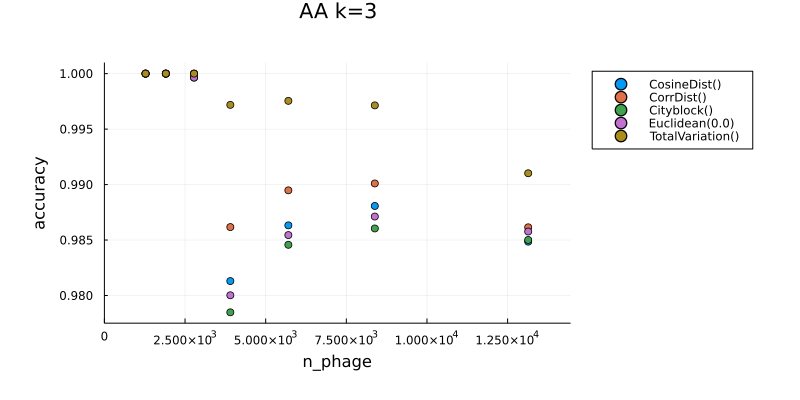

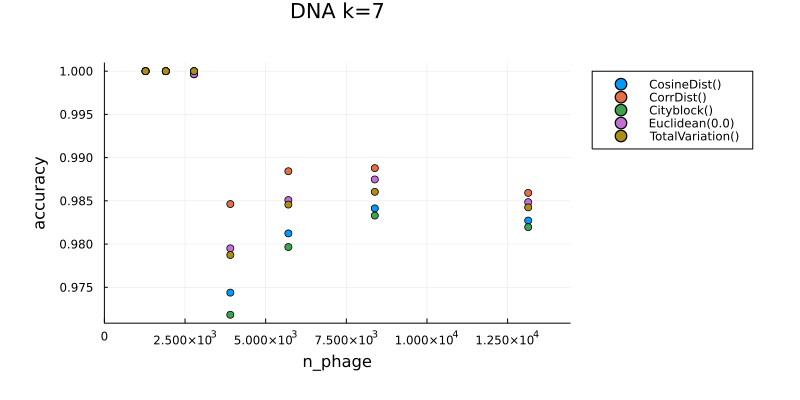

In [18]:
for (grammar, k) in ("AA" => aa_k, "DNA" => dna_k)
    is_right_grammar = results[!, "grammar"] .== grammar
    xs = []
    ys = []
    for distance_metric in keys(distance_matrix_map)
        is_right_distance_metric = map(dm -> dm == distance_metric, results[!, "distance_metric"])
        indices = is_right_grammar .& is_right_distance_metric
        xs_ = results[indices, "n"]
        ys_ = [results[findfirst(indices .& (results[!, "n"] .== x)), "genus_accuracy"] for x in xs_]
        push!(xs, xs_)
        push!(ys, ys_)
    end 
    labels = hcat(replace.(string.(keys(distance_matrix_map)), "Distances." => "")...)
    scale = 400
    p = StatsPlots.scatter(
        xs,
        ys,
#         ylims = (minimum(minimum.(ys)) * .9, 1.2),
        ylims = (minimum(minimum.(ys)) * 0.999, maximum(maximum.(ys)) * 1.001),
        xlims = (0, maximum(maximum.(xs)) * 1.1),
        labels = labels,
        legend = :outertopright,
        size = (2 * scale, scale),
        ylabel = "accuracy",
        xlabel = "n_phage",
        margins = StatsPlots.cm,
        title = "$(grammar) k=$k"
    )
    display(p)
    StatsPlots.savefig(p, "$DIR/$(grammar)-k$(k)-distance-metric-accuracy.svg")
    StatsPlots.savefig(p, "$DIR/$(grammar)-k$(k)-distance-metric-accuracy.png")
end

In [ ]:
# euclidean/city_block for assignment and correlation/total_variation for outlier tresholding??

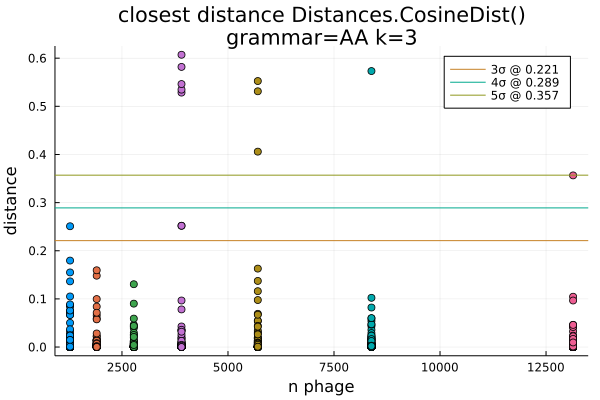

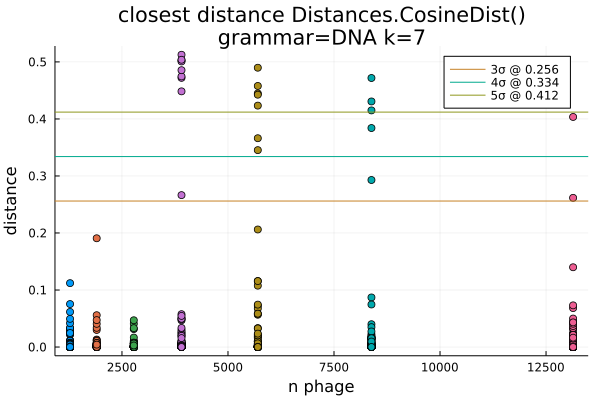

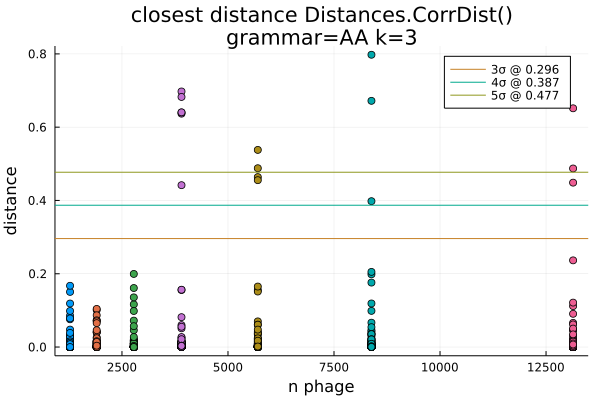

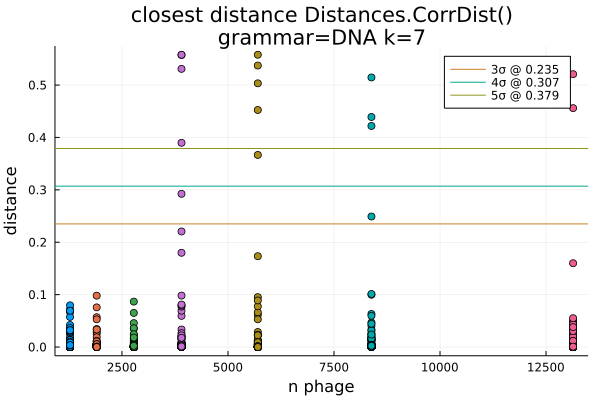

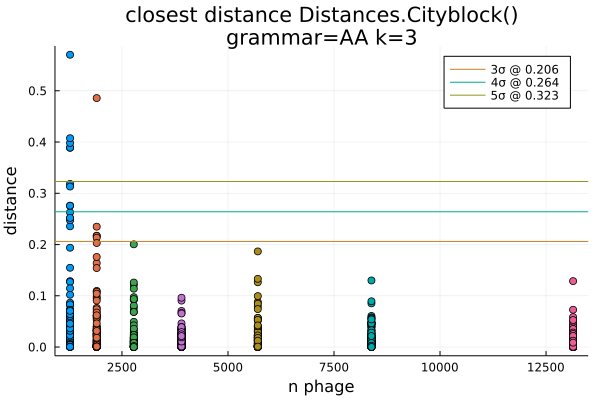

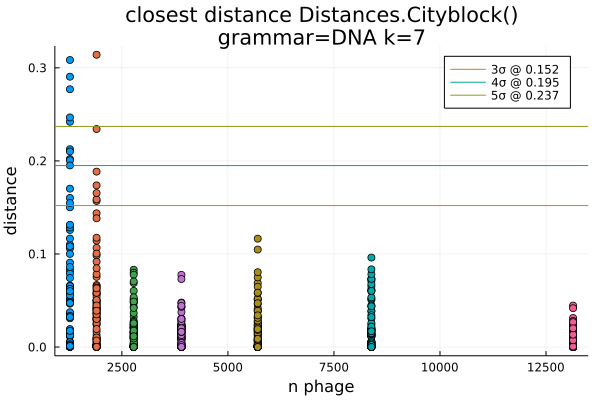

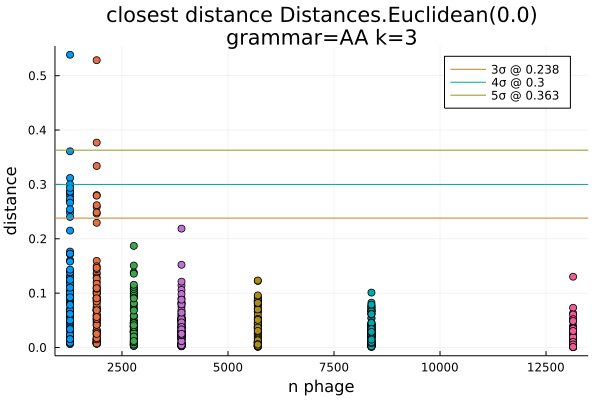

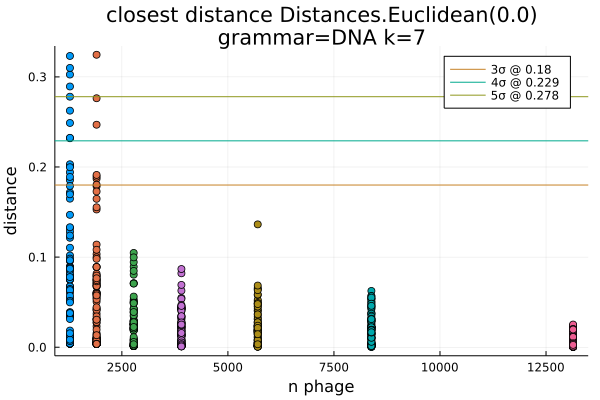

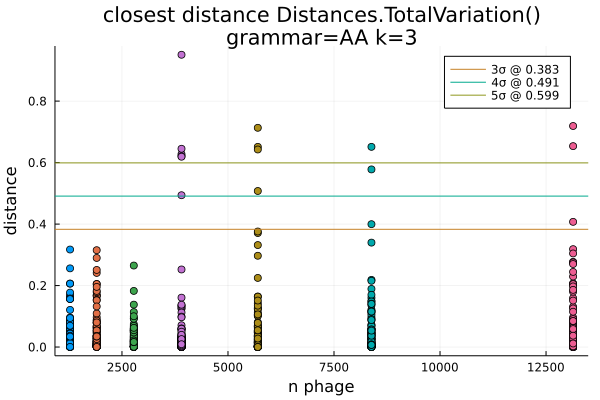

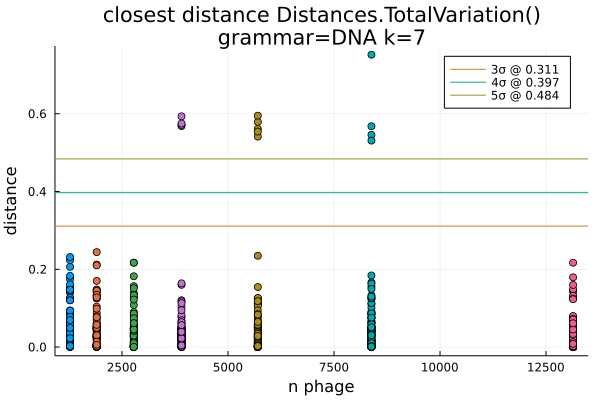

In [19]:
for distance_metric in collect(keys(distance_matrix_map))
    is_right_distance_metric = map(m -> m == distance_metric, results[!, "distance_metric"])
    for (grammar, k) in ("AA" => aa_k, "DNA" => dna_k)
        is_right_grammar = results[!, "grammar"] .== grammar
        xs = []
        ys = []
        for x in sort(unique(results[!, "n"]))
            is_right_n = results[!, "n"] .== x
            i = findfirst(is_right_grammar .& is_right_distance_metric .& is_right_n)
            if !isnothing(i)
                ys_ = results[i, "min_distances"]
                # drop the 0s since they aren't helpful
                ys_ = filter(y -> y > 0, ys_)
                ys_ = StatsBase.sample(ys_, min(100, length(ys_)), replace=false)
                push!(ys, ys_)
                push!(xs, fill(x, length(ys_)))
            end
        end
#         ys = [r/esults[findfirst(indices .& ()), "min_distances"] for x in xs]
        p = StatsPlots.scatter(
            xs,
            ys,
            xlabel = "n phage",
            ylabel = "distance",
#             legend = false,
            labels= "",
            title = "closest distance $(distance_metric)\ngrammar=$(grammar) k=$k"
        )
        m = Statistics.mean(reduce(vcat, ys))
        σ = Statistics.std(reduce(vcat, ys))
        σ3 = round(m+3σ, digits=3)
        σ4 = round(m+4σ, digits=3)
        σ5 = round(m+5σ, digits=3)
        p = StatsPlots.hline!(p,
            [[σ3], [σ4], [σ5]],
            labels = ["3σ @ $(σ3)" "4σ @ $(σ4)" "5σ @ $(σ5)"]
        )
        display(p)
        StatsPlots.savefig(p, "$DIR/$(grammar)-k$(k)-$(distance_metric)-closest-neighbor.png")
        StatsPlots.savefig(p, "$DIR/$(grammar)-k$(k)-$(distance_metric)-closest-neighbor.svg")
    end
end

In [ ]:
# AA 2
# DNA 5

# total variation
# species 0.1
# genus 0.2
# family 0.3

# correlation
# species 0.2
# genus 0.4
# family 0.6

# cosine
# species 0.1
# genus 0.2
# family 0.3

# euclidean
# city block

In [ ]:
# corr_distance = 0:2
# cosine and total variation = 0:1

In [ ]:
# Distances.cosine_dist(a, b)

In [ ]:
# Distances.cosine_dist(a ./ sum(a), b ./ sum(b))

In [ ]:
# Distances.totalvariation(a ./ sum(a), b ./ sum(b))